In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

random.seed(42)

C:\Users\Admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"



<a id='ab'></a>
##  A/B тестирование

A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель и улучшают ли.

Типичное применение в веб-дизайне — исследование влияния цветовой схемы, расположения и размера элементов интерфейса на конверсию сайта.

Конверсия (Conversion Rate) в интернет-маркетинге — это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах. 



В теории принципы A/B тестирования невероятно просты:

- Выдвигаем предположение о том, что какое-то изменение (например, персонализация главной страницы) увеличит конверсию интернет-магазина.

- Создаем альтернативную версию сайта «Б» — копию исходной версии «А» с изменениями, от которых мы ждем роста эффективности сайта.

- Всех посетителей сайта случайным образом делим на две равные группы: одной группе показываем исходный вариант (контрольная группа) , второй группе (тестовой) — альтернативный. Одновременно измеряем конверсию для обеих версий сайта.

- Определяем статистически достоверно победивший вариант.

Мы будем анализировать результаты A/B тестирования двух версий дизайна кнопки сайта интернет-магазина. 

Целевым действием считаем клик по этой кнопке. 

Первые три этапа А/В тестирования за нас провели, результаты предоставили в виде файла ab_dataset.csv. Нам осталось выполнить четвертый пункт.

**Задание **

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [2]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Посмотрим, сколько посетителей заходио на сайт (количество строк в нашем датафрейме)

In [3]:
#количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [4]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Из сообщений следует, что пропущенных значений нет.

Конверсия по всем посетителям

In [7]:
p_all=df['converted'].mean()
print("Конверсия по всем посетителям: {} %".format(p_all*100))

Конверсия по всем посетителям: 11.96591935560551 %


In [8]:
# можно и так:
sum(df['converted'].values)/n_rows

0.11965919355605512

Давайте посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`) и постараемся получить ответы на следующие вопросы:

- Какова вероятность клика для посетителей из контрольной группы (старый дизайн)?

- Какова вероятность клика для посетителей из тестовой группы (новый дизайн кнопки)?

- Каково соотношение размеров тестовой и контрольный групп? Какова вероятность, что очередной посетитель будет направлен на версию со старым дизайном? С новым дизайном?

In [16]:
df_grp = df.groupby('group')
df_grp.describe().T

group                  control      treatment
user_id   count  147202.000000  147276.000000
          mean   788123.098035  787825.226283
          std     91278.896888   91142.800641
          min    630002.000000  630000.000000
          25%    709287.000000  708729.500000
          50%    788053.500000  787837.500000
          75%    867155.500000  866693.750000
          max    945998.000000  945999.000000
converted count  147202.000000  147276.000000
          mean        0.120399       0.118920
          std         0.325429       0.323695
          min         0.000000       0.000000
          25%         0.000000       0.000000
          50%         0.000000       0.000000
          75%         0.000000       0.000000
          max         1.000000       1.000000
revenue   count  147202.000000  147276.000000
          mean       87.431896     116.496238
          std       102.424926     102.732069
          min         0.000000       0.000000
          25%         0.000000       0.000000
          50%         0.000000     100.000000
          75%       250.000000     250.000000
          max       250.000000     250.000000

In [20]:
df_grp.describe()['converted']

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,0.120399,0.325429,0.0,0.0,0.0,0.0,1.0
treatment,147276.0,0.118920,0.323695,0.0,0.0,0.0,0.0,1.0


Ответы на остальные вопросы можно найти, например, так:

In [12]:
#объем тестовой группы
n_rows_treat = len(df[df['group'] == 'treatment'])

#объем контрольной группы
n_rows_contr = n_rows-n_rows_treat

print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(n_rows_treat/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(n_rows_contr/n_rows))


Соотношение размеров тестовой и контрольной групп: 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.49987435394155083


**Задание **

А теперь ответьте на главный вопрос данного этапа:  выявил ли предварительный анализ, что дизайн кнопки влияет на конверсию и если да, то как именно?

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Конверсия сайта со старым дизайном не меньше, чем с новым"

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения, т.е. доли, кликнувших посетителей в контрольной и тестовой выборках.

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [22]:
#Z-статистика
import statsmodels.api as sm
import statsmodels

convert_contr = sum(df.query("group == 'control'")['converted'])
convert_treat = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_treat, convert_contr], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print("Z-статистика={},  p_value={}".format(z_score, p_value))

z_crit_value = 1.96

if abs(z_score) > z_crit_value:
    print("Мы можем отклонить нулевую гипотезу!")
else:
    print("Нам не удалось отвергнуть нулевую гипотезу")

Z-статистика=-1.2369217547321678,  p_value=0.8919419336512124
Нам не удалось отвергнуть нулевую гипотезу


#### Проведение вычислений. $T$-test.

In [24]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['converted'],
                                                              df.query("group == 'control'")['converted'],
                                                              alternative="larger",
                                                              usevar='unequal')

print("T-статистика={},  p_value={}".format(t_score, p_value))

if abs(t_score) > z_crit_value:
    print("Мы можем отклонить нулевую гипотезу!")
else:
    print("Нам не удалось отвергнуть нулевую гипотезу")

T-статистика=-1.2369191070650987,  p_value=0.8919409489056581
Нам не удалось отвергнуть нулевую гипотезу


#### Проведение вычислений. $Mann–Whitney$-test.

In [25]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['converted'], 
                         df.query("group == 'control'")['converted'],
                         alternative="greater")
print("W-статистика={},  p_value={}".format(w_score, p_value))

if abs(w_score) > z_crit_value:
    print("Мы можем отклонить нулевую гипотезу!")
else:
    print("Нам не удалось отвергнуть нулевую гипотезу")

W-статистика=10823622516.0,  p_value=0.8919415509213815
Мы можем отклонить нулевую гипотезу!


**Задание **

Посмотрели на результаты стат тестов, какая гипотеза оказалась верна?

### Мы не можем отклонить нулевую гипотезу! => Конверсия сайта со старым дизайном не меньше, чем с новым

<a id='m12'></a>
### Ошибки первого и второго рода

|  | | | |
|----------|:---------|:--------|:---------|
|  | | 	Верная гипотеза: | |
|  |     | $H_0$   | $H_1$    |
| Результат применения критерия: | $H_0$   |$H_0$ верно принята  |$H_0$ неверно принята (ошибка II рода)  |  
|  |$H_1$   |$H_0$ неверно отвергнута(ошибка I рода)  | $H_0$ верно отвергнута   |



Уровень значимости (статистическая значимость, statistical significance) $\alpha$ - это и есть вероятность ошибки первого рода, т. е. вероятность принятия альтернативной гипотезы при условии, что на самом деле верна нулевая гипотеза. 

Обозначим  $\beta$  вероятность ошибки второго рода. 

Величина  $1-\beta$ называется *статистической мощностью* (statistical power) критерия. По сути мощность показывает, сколько значений, соответствующих альтернативной гипотезе, мы действительно отнесем к альтернативной гипотезе

![asd](https://habrastorage.org/files/475/9e5/ebc/4759e5ebcfc54b11a852704017d2d8ac.png)

![mem](https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg?fit=960%2C720&ssl=1)

## bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [26]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


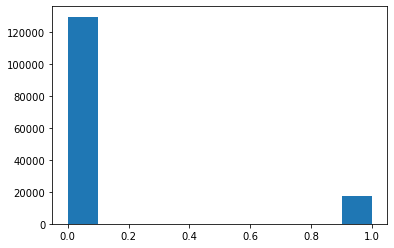

In [27]:
plt.hist(df.loc[df['group']=='treatment', 'converted']);

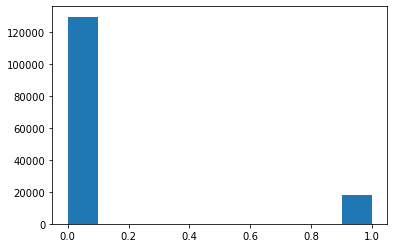

In [28]:
plt.hist(df.loc[df['group']=='control', 'converted']);

In [29]:
b = df.loc[df['group']=='treatment', 'converted'].values
a = df.loc[df['group']=='control', 'converted'].values

In [30]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

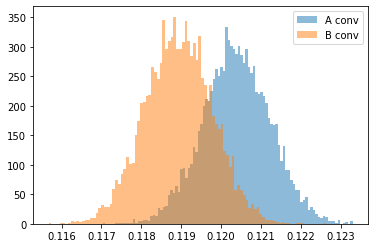

In [31]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [32]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(0.11872800641295635, 0.12204997214711756)

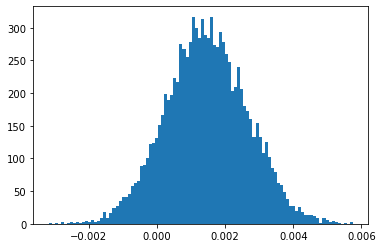

In [33]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [34]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.8898

### Мы не можем отклонить нулевую гипотезу! => Конверсия сайта со старым дизайном не меньше, чем с новым